In [102]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from statistics import mode
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Conv3D,MaxPooling3D, Conv2D, MaxPooling2D, Dense, Reshape,Flatten
from functools import partial
from tensorflow.keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def load_data_small(arg, testOrtrain):
    files = glob.glob("./Data/" + testOrtrain + " set/" + arg + "/*")
    img_arr = []
    for f in files:
        i = cv2.imread(f)
        height, width, channel = i.shape[:3]
        i = cv2.resize(i,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
        img_arr.append(i)
        
    return np.array(img_arr)

In [4]:
catergories = ["bridge","coast","mountain","rainforest"]
extracted_data = []
val_data = []
testing_data = []
for c in catergories:
    all_training = load_data_small(c,"Training")
    sz = int(all_training.shape[0]*0.8)   
    extracted_data.append(all_training[:sz])
    val_data.append(all_training[sz:])
    testing_data.append(load_data_small(c,"Testing"))

In [5]:
def formatCNNInput(data):
    x = np.array(data)
    num_catergories = x.shape[1]
    x_train = x.reshape((x.shape[0]*x.shape[1], x.shape[2], x.shape[3], x.shape[4], 1))

    y = []
    for i in range(4):
        y.append(np.tile(i,(num_catergories,1)))
    y_train = np.vstack((y[0],y[1],y[2],y[3]))
    
    return x_train, y_train

x_train, y_train = formatCNNInput(extracted_data)
x_val, y_val = formatCNNInput(val_data)
x_test, y_test = formatCNNInput(testing_data)

### Model 1

In [6]:
model1 = keras.models.Sequential([
    Conv3D(filters=32, kernel_size=(4,4,1), input_shape=(128,128, 3, 1)),
    keras.layers.MaxPooling3D(pool_size=(2,2,3)),
    Reshape((62,62,32)),
    Conv2D(filters=16, kernel_size=4),
    keras.layers.MaxPooling2D(pool_size=2),
    Conv2D(filters=8, kernel_size=4),
    keras.layers.MaxPooling2D(pool_size=2),
    Conv2D(filters=4, kernel_size=4),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=4, activation='softmax'),
])

optim = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Nadam'
)

model1.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optim,
    metrics=["accuracy"])

model1.load_weights("Trained_Model/cnn_classifier/cnn")

In [123]:
score = model1.evaluate(x_test, y_test)

5/5 [==============================] - 1s 104ms/step - loss: 1.2939 - accuracy: 0.6214


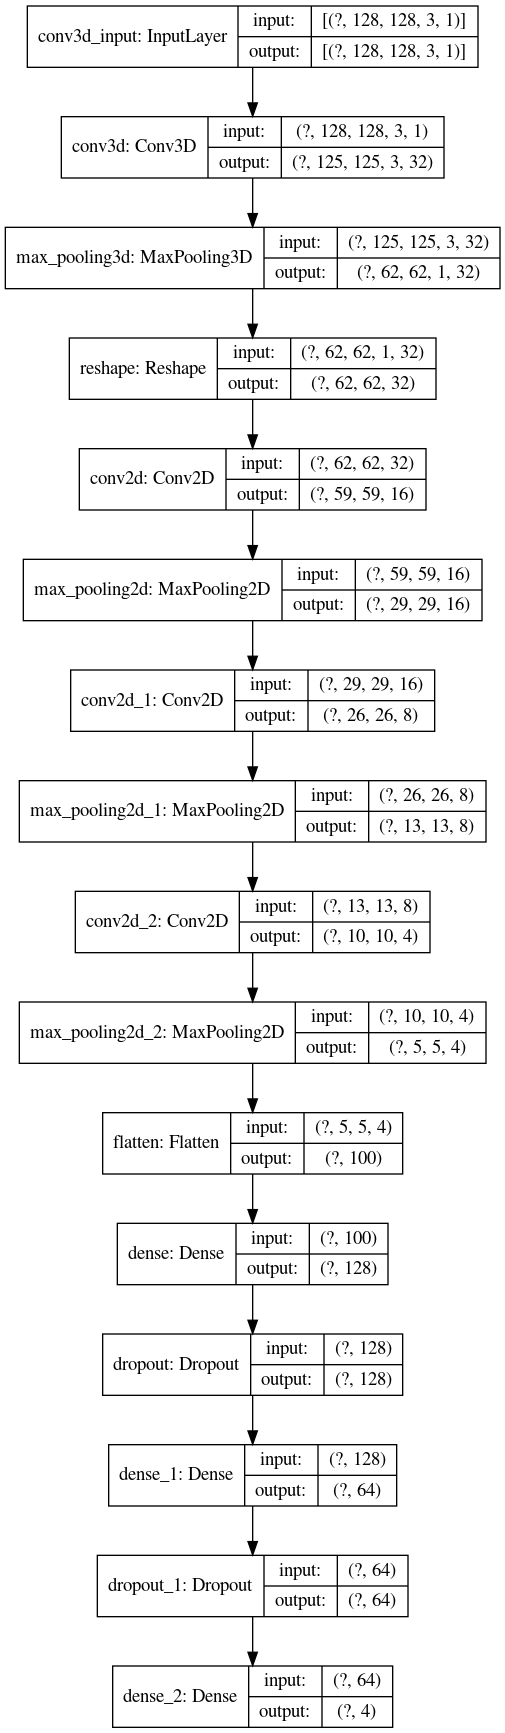

In [104]:
plot_model(model1, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

### Model 2

In [13]:
model2 = keras.models.Sequential([
    Conv3D(filters=32, kernel_size=(12,12,1), input_shape=(128,128, 3, 1)),
    keras.layers.MaxPooling3D(pool_size=(2,2,3)),
    Reshape((58,58,32)),
    Conv2D(filters=16, kernel_size=4),
    keras.layers.MaxPooling2D(pool_size=2),
    Conv2D(filters=8, kernel_size=4),
    keras.layers.MaxPooling2D(pool_size=2),
    Conv2D(filters=4, kernel_size=4),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=4, activation='softmax'),
])

optim = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Nadam'
)

model2.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optim,
    metrics=["accuracy"])

model2.load_weights("Trained_Model/cnn_classifier2/cnn")

### Own image

In [113]:
y_train.max()

3

In [122]:
def load_self_data(num_feat):
    files = glob.glob("./self-data/*")
    img = []
    for fi in files:
        print(fi)
        im = cv2.imread(fi)
        im = cv2.resize(im,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
        img.append(im)
        
    img_arr = np.array(img)
    
    f = [None]*4
    for i in range(img_arr.shape[0]):
        pic = img_arr[i]
        pic = pic.reshape((1,128,128,3,1))
        print(model1.predict(pic))
#         scores = model1.evaluate(pic, np.array(i).reshape(1,1))
#         print(scores)
    
    return img_arr

own_img = load_self_data(4)

./self-data/bridge.jpeg
./self-data/rainforest.jpeg
./self-data/mountain.jpeg
./self-data/coast1.jpeg
[[7.6230121e-01 2.0832574e-01 2.9360587e-02 1.2445411e-05]]
[[8.0289612e-07 1.2562810e-09 1.7317518e-06 9.9999750e-01]]
[[4.6558050e-04 7.4496865e-01 2.5430638e-01 2.5933312e-04]]
[[3.7025174e-04 9.7090054e-01 2.8681116e-02 4.8008631e-05]]


In [49]:
firstlayer = keras.models.Sequential(model1.layers[:4])
firstlayer.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optim,
    metrics=["accuracy"])
out = firstlayer(x_train, y_train)

### Plot Filter

In [50]:
firstlayer.layers

conv2d (4, 4, 32, 16)


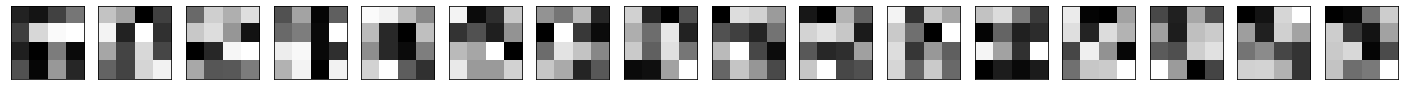

In [96]:
fig,ax = plt.subplots(figsize=(20,2))
plt.tight_layout()
# summarize filter shapes

layer = firstlayer.layers[3]
# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)



# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)


# plot first few filters
n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, 0, i]
    # plot each channel separately

    # specify subplot and turn of axis
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :], cmap='gray')
    ix += 1
    
    
# show the figure
# plt.show()
fig.savefig("weights.jpeg", bbox_inches='tight')

conv2d (4, 4, 32, 16)


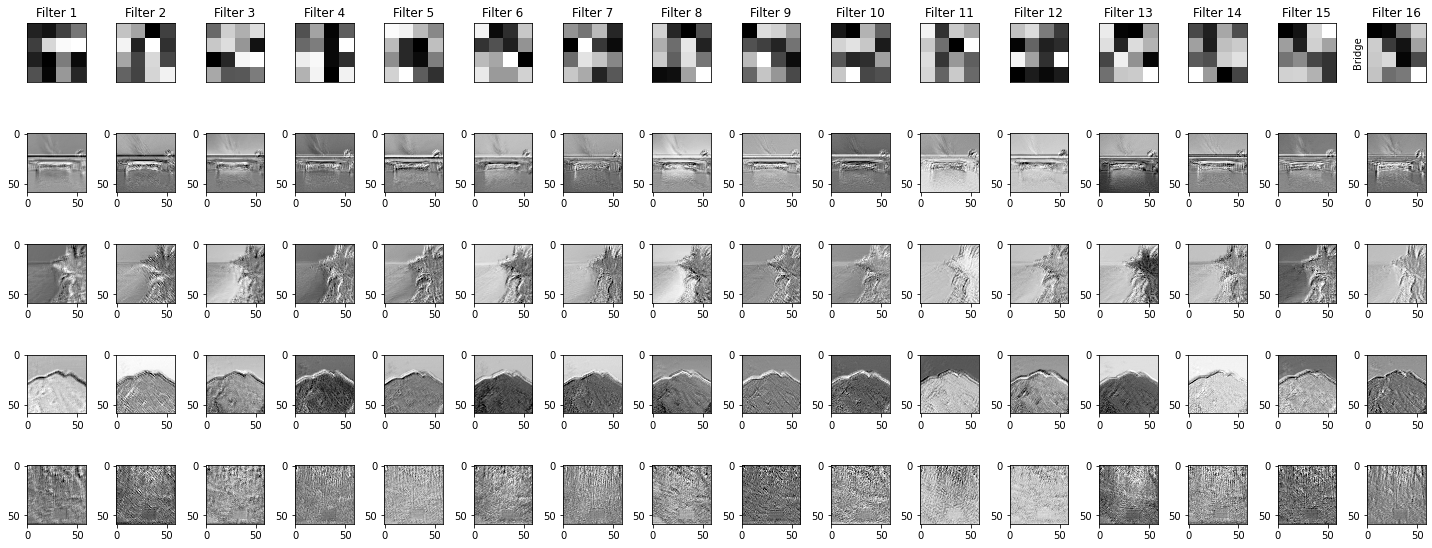

In [101]:
fig,ax = plt.subplots(figsize=(20,8))
plt.tight_layout()
# summarize filter shapes

layer = firstlayer.layers[3]
# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)



# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)


# plot first few filters
n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, 0, i]
    # plot each channel separately

    # specify subplot and turn of axis
    ax = plt.subplot(5, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    title = "Filter " + str(ix)
    ax.set_title(title)
    # plot filter channel in grayscale
    plt.imshow(f[:, :], cmap='gray')
    ix += 1
    
    
data = [5,170,267,430]
# for i in range (16):
for index, cl in enumerate(data):
    for i in range (16):
        plt.subplot(5, 16, 16+16*index+i+1)
        
        if (i == 0):
            ax.set_ylabel("Bridge")
            
        plt.imshow(out[cl,:,:,i],cmap='Greys')
    
    
# show the figure
plt.tight_layout()
# plt.show()
fig.savefig("cnn_fm.jpeg", bbox_inches='tight')

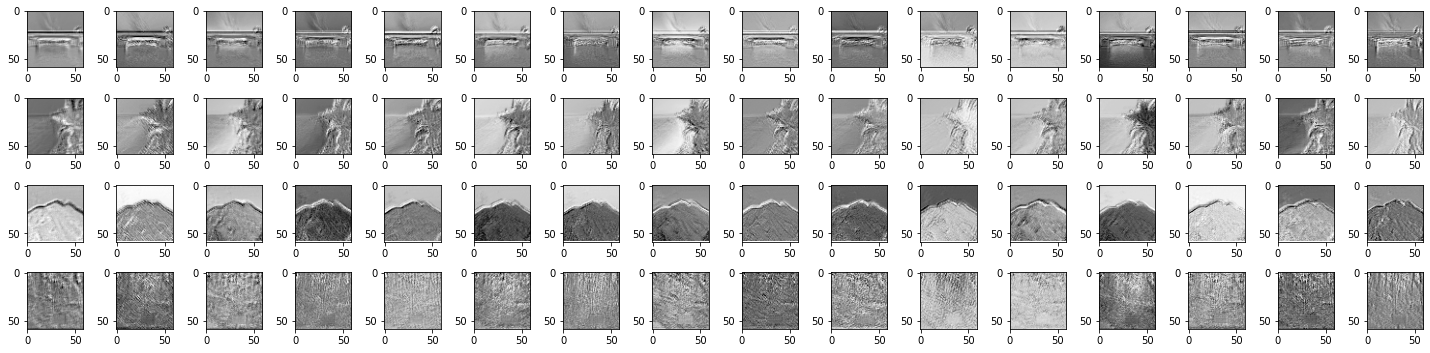

In [94]:
fig,ax = plt.subplots(figsize=(20,5))

data = [5,170,267,430]
# for i in range (16):
for index, cl in enumerate(data):
    for i in range (16):
        plt.subplot(4, 16, 16*index+i+1)
        plt.imshow(out[cl,:,:,i],cmap='Greys')
        
plt.tight_layout()
plt.show()
fig.savefig("fm.jpeg", bbox_inches='tight')

### Plot Feature Maps

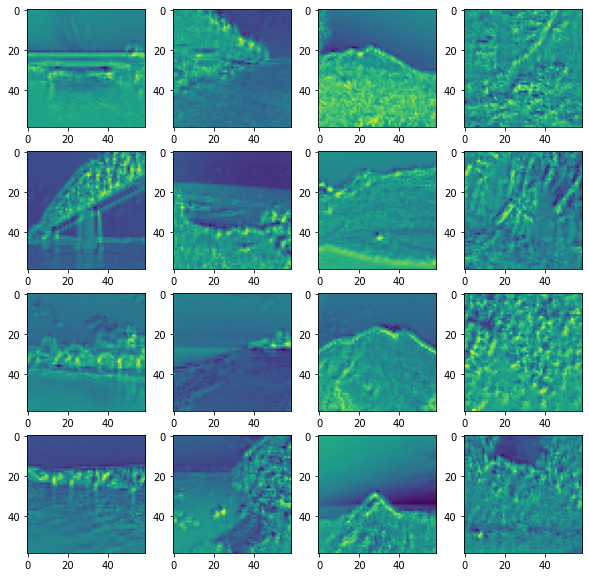

In [52]:
fig,ax = plt.subplots(figsize=(10,10))
f = 2
data = [5,133,265,397,10,134,266,398,20,135,267,399,50,140,290,400]
for i, pic in enumerate(data):
    plt.subplot(4,4,i+1)
    plt.imshow(out[pic,:,:,f])

plt.show()

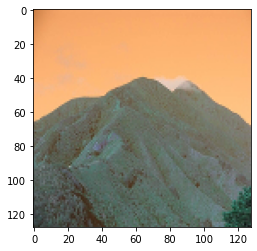

In [88]:
plt.imshow(x_train[267, :, :, :, 0])

In [54]:
out[5,:,:,:].shape

TensorShape([59, 59, 16])